# Squash video from 1080x1920 to 1920x1080

In [3]:
import cv2
from IPython.display import display, Image

# open video
video_path = 'E:/NUS/5003/Camera_cali/ivy_data/ARGait_P_JS_Freewalk_31-01-2024_10-09-20/output.mp4'
output_video_path = 'E:/NUS/5003/Camera_cali/ivy_data/ARGait_P_JS_Freewalk_31-01-2024_10-09-20/squash.mp4'
cap = cv2.VideoCapture(video_path, cv2.CAP_ANY)
cap

In [4]:
if not cap.isOpened():
    print("Error: Could not open video.")
else:
    # get frame height and width
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))

    # stretching factor 
    scale_x = 1080/frame_width  
    scale_y = 1920/frame_height  

# new video write to .mp4 format
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
out = cv2.VideoWriter(output_video_path, fourcc, 20.0, (int(frame_width * scale_x), int(frame_height * scale_y)))

while cap.isOpened():
    
    # read video frames
    ret, frame = cap.read()
    if not ret:
        break
    
    # sqush video
    new_width = int(frame_width * scale_x)
    new_height = int(frame_height * scale_y)
    resized_frame = cv2.resize(frame, (new_width, new_height))

    # write to new video
    out.write(resized_frame)

cap.release()
out.release()

print("Stretched video saved successfully.")

# CUT SINGLE video into frames

In [625]:
import cv2
import os
from moviepy.video.io.VideoFileClip import VideoFileClip
import imageio

folder_path = 'E:/NUS/5003/A_3Dtransform/ivy_data/low9/ARGait_P_Uploader_Freewalk_14-03-2024_20-03-24_noAR.o.mp4'
output_folder = 'E:/NUS/5003/A_3Dtransform/ivy_data/low9/frames_30/'
os.makedirs(output_folder, exist_ok=True)
cap = cv2.VideoCapture(folder_path)


def split_video_into_frames(video_path, output_folder, frame_rate):
    video_clip = VideoFileClip(video_path)
    frame_interval = 1 / frame_rate
    for i, frame in enumerate(video_clip.iter_frames(fps=frame_rate, dtype='uint8')):
        image_filename = f"{output_folder}/%s.png"%i
        # save frame as image
        video_clip.save_frame(image_filename, t=i * frame_interval)
    video_clip.reader.close()

split_video_into_frames(folder_path,output_folder, 30.013)   # last number is frame rate HZ


# Camera Martix and LiDAR data

In [2]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


In [843]:
lidar_df = pd.read_csv('E:/NUS/5003/A_3Dtransform/ivy_data/low9/lidar.csv')  #   lidar data
#frame_info_df = pd.read_csv('E:/NUS/5003/A_3Dtransform/ivy_data/ivy1/HSTO_info.csv')  #  HS+TO frame number
video_path = 'E:/NUS/5003/A_3Dtransform/ivy_data/low9/ARGait_P_Uploader_Freewalk_14-03-2024_20-03-24_noAR.o.mp4'
avg_camera_mtx = np.array([[ 2.17306343e+03,  0.00000000e+00,  5.02828061e+02],
       [ 0.00000000e+00,  2.19259497e+03, -1.05449168e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

#avg_camera_mtx = np.array([[2.47623460e+03, 0.00000000e+00, 7.02787874e+02],
#       [0.00000000e+00, 2.51552384e+03, 1.10708727e+02],
#       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
#

#camera_mtx1 = pd.read_csv(os.getcwd()+'/ivy_data/LabCamera/parameter_mtx1.csv')
#camera_mtx2 = pd.read_csv(os.getcwd()+'/ivy_data/LabCamera/parameter_mtx2.csv')

# get average camera matrix
# have done twice calibration

#camera_mtx1 = camera_mtx1.iloc[:,1:]
#camera_mtx2 = camera_mtx2.iloc[:,1:]
#camera_mtx1 = np.array(camera_mtx1)
#camera_mtx2 = np.array(camera_mtx2)
#avg_camera_mtx = (camera_mtx1+camera_mtx2) /2  
#avg_camera_mtx = np.array([[ 2.17306343e+03,  0.00000000e+00,  5.02828061e+02],
#       [ 0.00000000e+00,  2.19259497e+03, -1.05449168e+02],
#       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])


# Get video duration from openpose and lidar

In [844]:
# get videos duration of openpose and lidar
# openpose slow down video speed

def get_video_duration(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration_sec = frame_count / fps
    cap.release()
    return duration_sec


openpose_duration = get_video_duration(video_path)
lidar_duration = lidar_df.iloc[-1,0]

print(f'openpose video duration: {openpose_duration} s')
print('lidar video duration:%s s'%lidar_duration) 

openpose video duration: 4.633333333333334 s
lidar video duration:4.597927 s


# Heel Toe calculation


In [229]:
def visualize_point(image, heel,toe):# mark heel toe point on the image 
    cv2.circle(image, (heel), 5, (0, 255, 0), -1)  # 绿色是heel
    cv2.circle(image, (toe), 5, (0, 0, 255), -1)  # 红色是toe

    x, y, w, h = 100, 1000, 600, 600  # starting point x y, width, height
    roi = image[y:y+h, x:x+w]

    # show interest region with heel toe inside
    cv2.imshow('Image with Marked Points', roi)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return 

def visualize_lidar(image, image_path, heel, toe , openpose_duration, lidar_duration ):
    heel = np.array([heel])   
    toe =  np.array([toe])   

    # scale pixel resulotion(1920*1080) into lidar resulotion (144*256)

    heel = heel/7.5   # 1920/256 = 7.5
    toe = toe/7.5
    x_heel_lidar =  round(144-heel[0][0])
    y_heel_lidar =  round(heel[0][1])
    x_toe_lidar = round(144-toe[0][0])
    y_toe_lidar = round(toe[0][1])

    ## Match frameA of openpose with frameB of lidar

    frame_openpose = int(image_path.split('/')[-1].split('.')[0])
    #print(frame_openpose)
    lidar_fps = 1/30
    openpose_fps = 1/30
    openpose_time = frame_openpose*openpose_fps
    lidar_frame = round(  openpose_time/openpose_duration*lidar_duration/lidar_fps  )
    print(lidar_frame )

    # Depth image
    # gaussian filter for depth data
    kernel_size = (5, 5)  # 滤波器大小
    sigma_x = 0.3  # X 方向的高斯核标准差
    sigma_y = 0.1  # Y 方向的高斯核标准差
    depth_mtx = cv2.GaussianBlur(np.array(lidar_df.iloc[round(lidar_frame),1:]).reshape( 144,256), kernel_size, sigma_x, sigma_y)

    #depth_mtx = np.array(lidar_df.iloc[round(lidar_frame),1:]).reshape( 144,256)  # 144 row, 256 column    round(lidar_row)
    plt.imshow(np.flip( depth_mtx.T, axis =1), cmap='viridis', interpolation='nearest')
    plt.colorbar()  
    plt.title('Depth Matrix Heatmap')
    plt.show()
    return depth_mtx, x_heel_lidar , y_heel_lidar , x_toe_lidar  , y_toe_lidar 


def calculate_angle( depth_mtx, x_heel_lidar,y_heel_lidar,x_toe_lidar , y_toe_lidar , avg_camera_mtx ):
    heel_depth = depth_mtx[x_heel_lidar-1, y_heel_lidar-1]
    toe_depth =  depth_mtx[x_toe_lidar-1,  y_toe_lidar-1 ]
    Zc_heel = heel_depth * np.cos( np.arcsin(1.5/heel_depth) )
    Zc_toe = toe_depth * np.cos( np.arcsin(1.5/toe_depth) ) 
    #print('Heel depth: ',heel_depth, 'Toe depth: ',toe_depth,'\n')

    Xc_heel = Zc_heel*(x_heel_lidar-avg_camera_mtx[0,2])/avg_camera_mtx[0,0]
    Yc_heel = Zc_heel*(y_heel_lidar-avg_camera_mtx[1,2])/avg_camera_mtx[1,1]
    Xc_toe = Zc_toe*(x_toe_lidar-avg_camera_mtx[0,2])/avg_camera_mtx[0,0]
    Yc_toe = Zc_toe*(x_toe_lidar-avg_camera_mtx[1,2])/avg_camera_mtx[1,1]
    #print(Yc_heel,Yc_toe)
    
    ## for toe-off
    #cos_theta = abs( np.sqrt( (Xc_heel-Xc_toe)**2+ (Zc_heel-Zc_toe)**2 ) )  /(np.sqrt(  (Xc_heel-Xc_toe)**2+(Yc_heel-Yc_toe)**2+ (Zc_heel-Zc_toe)**2 )  )
    #theta = np.degrees(np.arccos(cos_theta))
    #print('len of th:',np.sqrt(  (Xc_heel-Xc_toe)**2+(Yc_heel-Yc_toe)**2+ (Zc_heel-Zc_toe)**2 ) )
    #print('cos:',theta)
    #
    ## for heel-strike
    #sin_theta = np.sqrt( (Yc_heel-Yc_toe)**2) /(np.sqrt(  (Xc_heel-Xc_toe)**2+(Yc_heel-Yc_toe)**2+ (Zc_heel-Zc_toe)**2 )  )
    #theta = np.degrees(np.arcsin(sin_theta))
    #print('sin:',theta)
    
    tan_theta = np.sqrt( (Yc_heel-Yc_toe)**2) /(np.sqrt(  (Xc_heel-Xc_toe)**2 + (Zc_heel-Zc_toe)**2 )  )
    print('tan:',np.degrees(np.arctan(tan_theta)) )
    print('len of foot:',np.sqrt(  (Xc_heel-Xc_toe)**2+(Yc_heel-Yc_toe)**2+ (Zc_heel-Zc_toe)**2 ) )
    

    return np.degrees(np.arctan(tan_theta))


In [918]:
#   #   #   start calculation   #   #   #
##########################################
##########################################
##########################################


In [7]:
hs_df = pd.read_excel('E:/NUS/5003/A_3Dtransform/ivy_data/result_HS.xlsx')
to_df = pd.read_excel('E:/NUS/5003/A_3Dtransform/ivy_data/result_TO.xlsx')

In [921]:
######### change frame  ##########
iter_number = 87
#################################
now_to = to_df.iloc[iter_number]
#now_hs = hs_df.iloc[iter_number]
print("processing frame details:\n",now_to)
image_path = 'E:/NUS/5003/A_3Dtransform/ivy_data/low9/frames_30/' +'%s.png'%int( now_to[0]+0)
image = cv2.imread(image_path)

# openpose coordinate defines y at the left bottom, while pixel coordinate define y at left upward, an img is 1920 height

heel = (int(now_to[2])  + 21 , 1920- int(now_to[3])  + 15  )  # heel
toe =  (int(now_to[4])  - 10 , 1920- int(now_to[5])  + 12  )  # toe

processing frame details:
 frame              85.000000
angle_openpose     38.510000
heel_x            291.903618
heel_y            561.063934
toe_x             348.716675
toe_y             515.861525
TO angle           62.975251
Name: 87, dtype: float64


In [922]:
visualize_point(image, heel, toe)

84


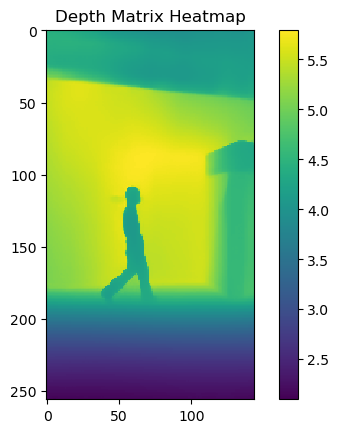

tan: 78.0056906091542
len of foot: 0.15065296818151225


78.0056906091542

In [923]:
depth_mtx, x_heel_lidar , y_heel_lidar , x_toe_lidar ,y_toe_lidar = visualize_lidar(image, image_path, heel, toe , openpose_duration, lidar_duration )
angle = calculate_angle( depth_mtx, x_heel_lidar,y_heel_lidar,x_toe_lidar , y_toe_lidar , avg_camera_mtx )
angle

In [924]:
now_to['TO angle'] = angle.copy()
to_df.iloc[iter_number] = now_to
to_df.to_excel('E:/NUS/5003/A_3Dtransform/ivy_data/result_TO.xlsx', index = False)

C:\Users\12\AppData\Local\Temp\ipykernel_16308\744928484.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  now_to['TO angle'] = angle.copy()


In [260]:
np.degrees( np.arcsin(np.sqrt(3)/2 )  )

59.99999999999999

#  Angle: ground floor to camera plane

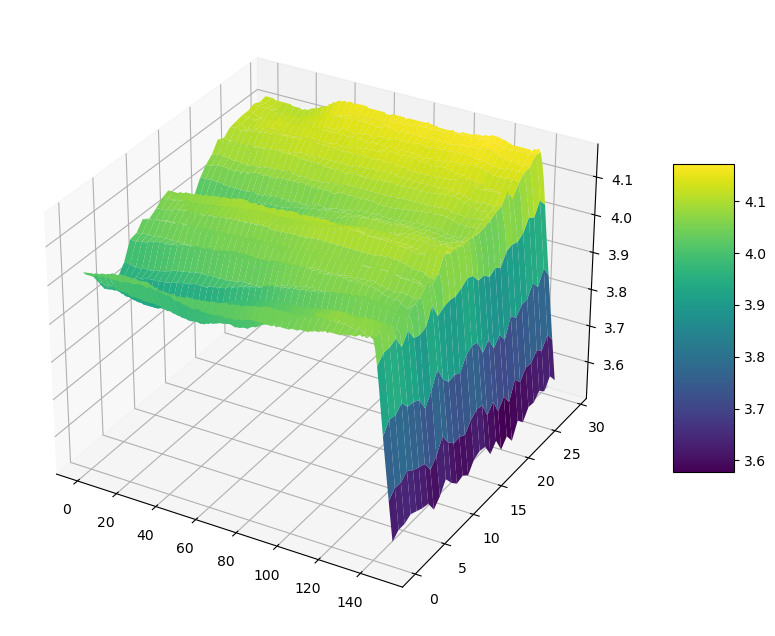

In [40]:
depth_of_camera = min(lidar_df.iloc[60,70:120])
camera_plane = np.argmin( lidar_df.iloc[60,40:120] )
depth_of_camera, camera_plane

## camera_plane = 71+40 =111

rows, cols = lidar_df.iloc[40:70,50:200].shape

# 创建一个网格
x = np.arange(cols)
y = np.arange(rows)
x, y = np.meshgrid(x, y)
# 绘制三维图像
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# 绘制曲面
surf = ax.plot_surface(x, y, lidar_df.iloc[40:70,50:200], cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

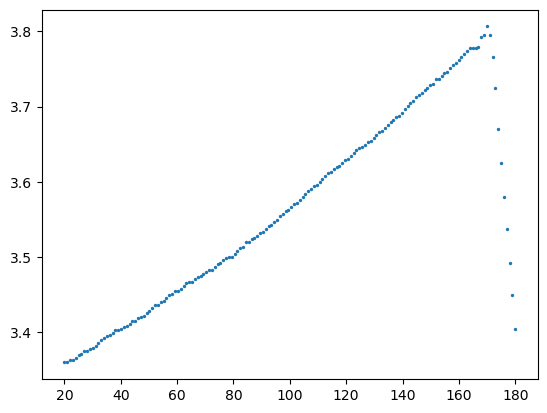

In [29]:
plt.scatter(np.linspace(20,180,160),lidar_df.iloc[44,20:180],s = 2)

In [30]:
### how to find the floor point?  finr the max depth in the region including wall-floor connecting line
floor_wall_intersection = np.argmax( lidar_df.iloc[60,160:210] )
floor_wall_intersection

## floor_wall_intersection = 13+160 = 173

9